In [10]:
import array
from glob import glob
import numpy as np
from scipy.spatial.distance import cdist, pdist
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from utils import get_complex, get_complex_from_distance_matrix, get_density_filtration, get_density_filtration_efficient, get_persistence
from utils import A, D, H, Lambda
from utils import get_Q_bar, polynomial_g, polynomial_g_on_s1

In [2]:
DATA_DIR = "./../../DATA/vanhateren/vanhateren_imc/"
DATA_PATCHES = "./../../DATA/vanhateren/vanhateren_patches/"

# Test on one file

In [3]:
def load_image(filename):
    with open(filename, 'rb') as handle:
        s = handle.read()
    arr = array.array('H', s)
    arr.byteswap()
    img = np.array(arr, dtype='uint16').reshape(1024, 1536)
    return img

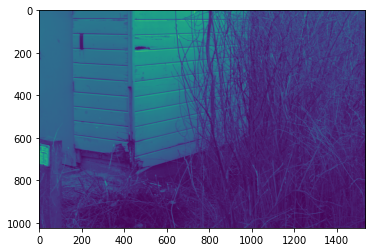

In [4]:
filename = DATA_DIR + "imk00110.imc"
img = load_image(filename)
plt.imshow(img)

In [5]:
def sample_patches_from_image(img, num=500, size=(3,3)):
    """Sample `num` patches of size `size` each from `img`
    Returns:
        patches: ndarray of shape (num, *size).
    """
    shape = img.shape
    anchor_x, anchor_y = [np.random.randint(0, shape_-size_, size=num) for shape_, size_ in zip(shape, size)]
    anchors_x = anchor_x[:, None, None] + np.arange(size[0])[None, :, None]
    anchors_y = anchor_y[:, None, None] + np.arange(size[1])[None, None, :]
    patches = img[anchors_x, anchors_y]
    return patches

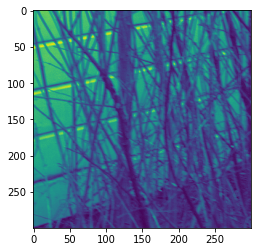

In [6]:
patches = sample_patches_from_image(img, 3, (300, 300))
plt.imshow(patches[0]) # Sample a bigger one to check if it's correct

## Extract all patches

In [7]:
files = glob(f"{DATA_DIR}*")

In [8]:
def load_image_and_extract_patches(filename, do_save=True):
    img = load_image(filename)
    patches = sample_patches_from_image(img, num=5000, size=(3,3))
    if do_save:
        save_to = f"{DATA_PATCHES}patches{filename[-9:-4]}.npy"
        np.save(save_to, patches)
    return patches

In [ ]:
np.random.seed(0)
all_patches = [load_image_and_extract_patches(f, do_save=False) for f in files]

In [ ]:
stacked_patches = np.stack(all_patches)
stacked_patches.shape

In [ ]:
np.save("./../../DATA/vanhateren/raw_patches.npy", stacked_patches)

## Preprocess and subset

In [5]:
stacked_patches = np.load("./../../DATA/vanhateren/raw_patches.npy")

In [3]:

def preprocess_extract(patches):
    """For patches from one image, preprocess them and return
    those with biggest D-norm.
    Params:
    -------
        patches: ndarray of shape (n, 9), a list of patches (from a single image).
    Return:
    -------
        points_new_basis: ndarray of shape (n//5, 8), pre-processed patches,
            with maximal D-norm, in the DCT basis."""
    n_points, dim = patches.shape
    
    patches[patches<=0] = 1.
    log_patches = np.log(patches)
    centered = log_patches - np.mean(log_patches, axis=1, keepdims=True)
    norms = np.diag(centered@(D@centered.T))
    top20_indices = np.argsort(-norms)[:n_points//5]
    top20 = centered[top20_indices]
    top20_normalized = top20/norms[top20_indices, None]
    points = top20_normalized
    points_new_basis = Lambda*(A.T@points.T).T
    
    return points_new_basis

In [7]:
np.diag(A.T@(D@A))

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [8]:
new_patch = preprocess_extract(stacked_patches[0].reshape(-1, 9))
new_patch.shape

(1000, 8)

In [9]:
flattened_patches = stacked_patches.reshape(*stacked_patches.shape[0:2], 9)
selected_patches = np.stack([preprocess_extract(p)
                             for p in tqdm(flattened_patches)])

<ipython-input-9-cb9a79fbfa97>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for p in tqdm(flattened_patches)])


  0%|          | 0/4167 [00:00<?, ?it/s]

In [10]:
np.save("./../../DATA/vanhateren/patches.npy", selected_patches)

In [11]:
selected_patches.shape

(4167, 1000, 8)

## Generate $\bar{Q}$

In [13]:
n_sample = 30
np.random.seed(0)
q_bar = get_Q_bar(n_sample)
np.save("./../data/Q_bar.npy", q_bar) 

In [14]:
n_sample = 150
np.random.seed(0)

q_bar = get_Q_bar(n_sample, neighborhood_size=0.05)
np.save("./../data/Q_bar_big_neighborhood.npy", q_bar)

# Old

In [ ]:
patches = np.load("./../data/M_100_10_q.npy")
points = patches.reshape(-1, 8)
close_points = get_Q(points=patches, n_sample=30)